## Problem 1 - Trichromacy

* colMatch.mat contains matrices and vectors related to the color matching experiment 
* variable P is an 31x3 matrix containing wavelength spectra for three “primary” lights, that could be used in a color-matching experiment.
* The function humanColorMatcher.p simulates a normal human observer in a color matching experiment. The input variable light should contain the wavelength spectrum of a test light. The variable primaries should contain the wavelength spectra of a set of primary lights. The function returns a 3-vector containing the observer’s “knob settings” - the intensities of each of the primaries that, when mixed together, appear identical to the test light.

In [1]:
import trichromacy as tri
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.io import loadmat
#Load given data
load_data = loadmat('colMatch.mat')
cones = load_data['Cones']
P = load_data['P']

Text(0, 0.5, 'Test light color spectra')

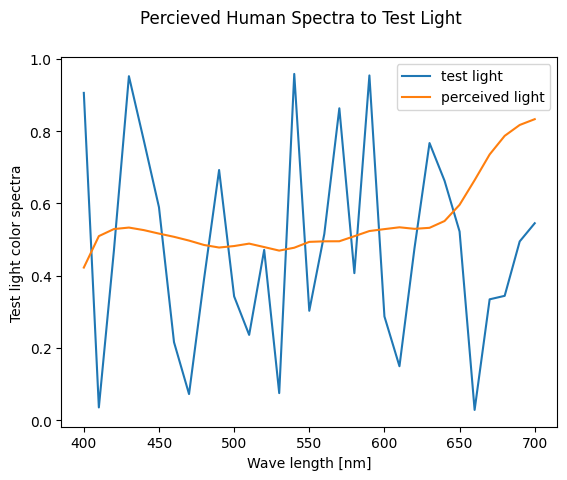

In [2]:
## a) 
## Create a test ligh with an arbitrary wavelength spectrum
test_light = np.random.rand(31,1)
## Use human_color_matcher to emulate an experiment
test_knob_out= tri.human_color_matcher(test_light,P)
## Compute the 31-dimensional wavelenght spectrum of the percieved light
test_knob_spectra = P@test_knob_out
## Plot the two spectra together 
freqs = np.linspace(400,700,31)
test_knob_out= tri.human_color_matcher(test_light,P)
test_knob_spectra = P@test_knob_out
freqs = np.linspace(400,700,31)
fig,axs = plt.subplots()
fig.suptitle('Percieved Human Spectra to Test Light')
axs.plot(freqs,test_light,label='test light')
axs.plot(freqs,test_knob_spectra,label='perceived light')
axs.legend()
plt.xlabel("Wave length [nm]")
plt.ylabel("Test light color spectra")

We can see that the human perception of color doesnt capture the whole light spectra of a given test light. This is due to the fact that human perception applies a linear transformation of the original spectra and converts it to a linear combination of primary lights, this dimensionality reduction forces the loss of information and so the transformed/perceived light is not exactly the same as the testlight.

In [2]:
## b)
## Characterize the human observer as a linear system 
## To characterize a linear system we must run an impulse response analysis and store the outputs as the row of the characterization matrix
impulse_inputs = np.identity(31)
M = tri.human_color_matcher(impulse_inputs,P)
## Create a test light with an arbitrary wavelength spectrum
test_light_1 = np.random.rand(31,1)
test_light_2 = np.random.rand(31,1)
test1_M = M@test_light_1
test1_Sim = tri.human_color_matcher(test_light_1,P)
test2_M = M@test_light_2
test2_Sim = tri.human_color_matcher(test_light_2,P)
if np.allclose(test1_M,test1_Sim) and np.allclose(test2_M,test2_Sim): ## all close function used as equal and equivalent did not work with verified equal arrays
    print('Chracterization successfull, succesfully tested characterization and simulation with two random test light')

Chracterization successfull, succesfully tested characterization and simulation with two random test light


In [3]:
## c)
## Verify that randomly generated light produces equal cone absorption as their perceived 3-primary matching light
test_light = np.random.rand(31,1)
avg_coneabs = tri.all_cones@test_light
perceived_rgb = M@test_light
perceived_spectra = P@perceived_rgb
avg_coneabs_perceived = tri.all_cones@perceived_spectra
print('Cone absorbption of test light: {}\nCone absorption of perceived light: {}'.format(avg_coneabs.T,avg_coneabs_perceived.T))
if np.allclose(avg_coneabs,avg_coneabs_perceived): ## all close function used as equal and equivalent did not work with verified equal arrays
    print('Succesfully verified that randomly generated light produces equal cone absorption as their perceived 3-primary matching light')
    print('This suggests a physiological explanation to the observed behaviour of the humanColorMatcher')



Cone absorbption of test light: [[4.25910857 3.5838375  3.69213025]]
Cone absorption of perceived light: [[4.25910857 3.5838375  3.69213025]]
Succesfully verified that randomly generated light produces equal cone absorption as their perceived 3-primary matching light
This suggests a physiological explanation to the observed behaviour of the humanColorMatcher


Now  that we have seen that the average cone response matches the perceived light for a randomly given light, we will proceed to prove that this is true for any light. To do this lets look any two lights  $\vec{l_1}$  an $\vec{l_2}$, for this two lights to produce the same perceived light: $ M * \vec{l_1} = M * \vec{l_2}$. This means that in the linear transformation applied by the visual system, are perceptualy the same. Which induces to the conclution that when trasnforming a 31-dimension light into a 3-dimension combination of primary color intensity, there is lost information. This lost information of linear system is characterized by its nullspace in a linear algebra point of view. So, if the cone light absorption provides a physiological explanation to the perceived light, this would mean that the same two lights $\vec{l_1}$  an $\vec{l_2}$ should produce the same cone absorption: $ Cones * \vec{l_1} = Cones * \vec{l_2}$, which in turns means that nullspaces of both systems should be the same: $ N\{ M \} = N\{ Cones \}$. To check if this is true we will calculate the nullspace for both linear systems using SVD, if its nullity (dimensionality of nullspace) is the same we can assume that the nullspaces are the same, as the nullspaces are defined by orthonormal basis.

In [5]:
## Mathematical demonstration
def get_nullspace(M): # Function that performs SVD decomposition and calculates the nullspace basis and its nullity 
    U, s, V = la.svd(M, full_matrices = True)
    ## Search for null basis 
    null_basis = []
    for i in range(len(V[0,:])-4):
        null_basis.append(V[:,i+3])
    null_basis.append(V[:])   
    return null_basis,len(null_basis)

Cones_null,Cones_nulity = get_nullspace(tri.all_cones)
M_null,M_nulity = get_nullspace(M)

print('Nullity of the Human Color Matcher (M): {} \nNullity of Cone Absorption (Cones): {}'.format(M_nulity,Cones_nulity))


Nullity of the Human Color Matcher (M): 28 
Nullity of Cone Absorption (Cones): 28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0, 0.5, 'Test light color spectra')

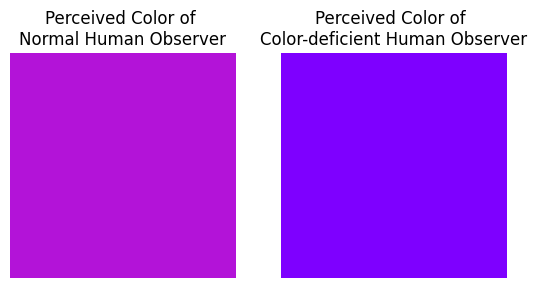

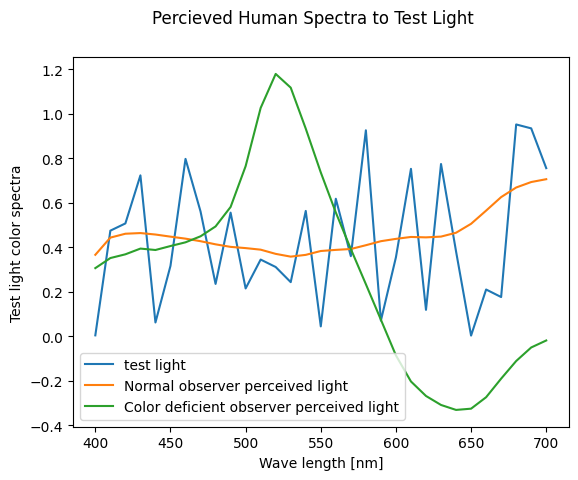

In [20]:
## d) altHumanColorMatcher simulates a color-deficient human observer
## i) for a random test light compare the knob settings for this observer compared to a normal human. 
test_light = np.random.rand(31,1)
n_perceived = M @ test_light # RGB perceived by normal human observer
cd_perceived = tri.alt_human_color_matcher(test_light,P) # RGB perceived by a color-deficient human observer
n_perceived_colorplot = np.stack([np.ones((500,500))*n_perceived[0],np.ones((500,500))*n_perceived[1],np.ones((500,500))*n_perceived[2]],axis=-1)#RGB square matrix for plot
cd_perceived_colorplot = np.stack([np.ones((500,500))*cd_perceived[0],np.ones((500,500))*cd_perceived[1],np.ones((500,500))*cd_perceived[2]],axis=-1)#RGB square matrix for plot
fig,axs = plt.subplots(1,2)# Plot perceived colors
axs[0].imshow(n_perceived_colorplot)
axs[0].set_title('Perceived Color of \nNormal Human Observer')
axs[0].axis('off')
axs[1].imshow(cd_perceived_colorplot)
axs[1].set_title('Perceived Color of \nColor-deficient Human Observer')
axs[1].axis('off')
## ii) Compute the cone absorption for the test light and for the perceived light (mixture of matchnig primaries)
## for both a color-defecient and a normal human observer
test_light = np.random.rand(31,1)
avg_coneabs = tri.all_cones@test_light # Average cone absorption for test light
n_perceived_rgb = M@test_light # Perceived RGB color by normal human observer
n_perceived_spectra = P@n_perceived_rgb # Perceived color spectra by normal human observer
n_avg_coneabs_perceived = tri.all_cones@perceived_spectra # Average cone absorption for perceived color spectra by normal human observer
cd_perceived_rgb = tri.alt_human_color_matcher(test_light,P) # Perceived RGB color by normal human observer
cd_perceived_spectra = P@cd_perceived_rgb # Perceived color spectra by normal human observer
cd_avg_coneabs_perceived = tri.all_cones@perceived_spectra # Average cone absorption for perceived color spectra by normal human observer
## Plot the spectra together 
freqs = np.linspace(400,700,31)
fig2,axs2 = plt.subplots()
fig2.suptitle('Percieved Human Spectra to Test Light')
axs2.plot(freqs,test_light,label='test light')
axs2.plot(freqs,n_perceived_spectra,label='Normal observer perceived light')
axs2.plot(freqs,cd_perceived_spectra,label='Color deficient observer perceived light')
axs2.legend()
plt.xlabel("Wave length [nm]")
plt.ylabel("Test light color spectra")

Now that we have viewed the diference in the cone absorption for a color-deficient and a normal observer, we will proceed to attempt to provide a diagnosis for the color-deficiency of the observer. To accomplish this we will analyze the cone absorption for the isolated primary colors for both the color-defecient and a normal observer.

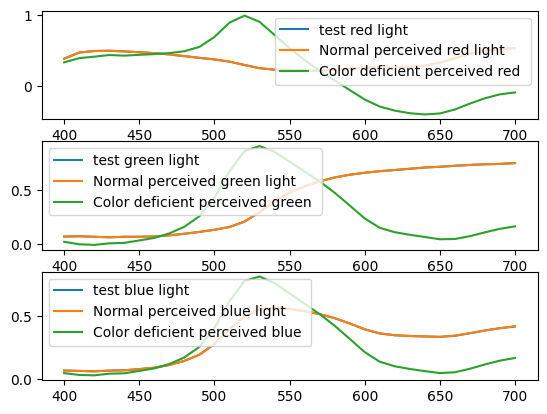

In [9]:
red_light = np.array([1,0,0])
red_spectra = P@red_light
green_light = np.array([0,1,0])
green_spectra = P@green_light
blue_light = np.array([0,0,1])
blue_spectra = P@blue_light
rgb_spectra = [red_spectra,green_spectra,blue_spectra]
figure,axs = plt.subplots(3)
freqs = np.linspace(400,700,31)
colors = ['red','green','blue']
for i in range(len(rgb_spectra)): 
    n_perceived_rgb = M@rgb_spectra[i] # Perceived RGB color by normal human observer
    n_perceived_spectra = P@n_perceived_rgb # Perceived color spectra by normal human observer
    n_avg_coneabs_perceived = tri.all_cones@n_perceived_spectra # Average cone absorption for perceived color spectra by normal human observer
    cd_perceived_rgb = tri.alt_human_color_matcher(rgb_spectra[i],P) # Perceived RGB color by normal human observer
    cd_perceived_spectra = P@cd_perceived_rgb # Perceived color spectra by normal human observer
    cd_avg_coneabs_perceived = tri.all_cones@cd_perceived_spectra # Average cone absorption for perceived color spectra by normal human observer
    # axs[i].suptitle('Percieved Human Spectra to {} Light'.format(colors[i]))
    axs[i].plot(freqs,rgb_spectra[i],label='test {} light'.format(colors[i]))
    axs[i].plot(freqs,n_perceived_spectra,label='Normal perceived {} light'.format(colors[i]))
    axs[i].plot(freqs,cd_perceived_spectra,label='Color deficient perceived {} '.format(colors[i]))
    axs[i].set_xlabel('wave length [nm]')
    axs[i].legend()

When stimulating a normal observer with a test light of isolated primary colors the perceived light is exactly the same as the test light, however when stimulating a color defecient observer with the same test light their perceived light is different. This color defecient observer has a low sensitivity in the range of 600nm - 700nm, and 400nm-500nm, but has a higher sensitivity in the range from 500nm-600nm. 